In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import gzip
import copy
import json
import scipy.stats as stats
from collections import defaultdict
import datetime
import time
import math
from scipy.stats import gaussian_kde
import pandas as pd
import scipy.stats 
import random
import os
import cv2
import matplotlib.image as mpimg
from tqdm import tqdm
import pickle

sys.path.append('/u/rakhasan/Desktop/reputation/twitterscraper/helpers')

pipa_path = '/data/rakhasan/pipa-dataset/'
openImg_path = '/data/rakhasan/bystander-detection/google-img-db/'


# Google Open Image

In [4]:
import csv

'''Find all images of people '''

path = '/data/rakhasan/bystander-detection/google-img-db/'
anno_file = path+'train-annotations-bbox.csv'
human_part = path+'class-ids-human-body-parts-and-mammal.txt'
classes = path + 'class-descriptions-boxable.csv'
out_path = 'select-image/'

person_class = '/m/01g317'

csvreader = csv.reader(open(classes,'r'))
human_parts = dict()
for h in open(human_part,'r'):
    human_parts[h.strip()]=''

class_ids=dict()
for c in csvreader:
    cid = c[0]
    name = c[1]
    class_ids[cid]=name
    if cid in human_parts:
        human_parts[cid]=name


human_parts.pop('/m/04rky',0) #remove 'mammal'

'Mammal'

In [5]:
'''Load annotations'''
csvreader = csv.reader(open(anno_file,'r'))
all_annotations = []
for anno in csvreader:
    all_annotations.append(anno)
del all_annotations[0] # delete header

KeyboardInterrupt: 

In [ ]:
'''Group all annotations for a specific photo'''
photo_annotations = defaultdict(list)
for a in all_annotations:
    photo_annotations[a[0]].append(a)

In [11]:
'''
Find out annotations containing person_class.
ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
'''
person_annotations = defaultdict(list)
for a in all_annotations:
    if a[2] == person_class:
        person_annotations[a[0]].append(a)
#pickle.dump(person_annotations, open(openImg_path+'person-annotations.pkl','wb'))

In [30]:
len(person_annotations), len(photo_annotations)

(248384, 1743042)

In [31]:
'''
Group images by number of people. Keep only images that are 
- labeled by human
- not a depiction
'''
person_anno_by_num =defaultdict(lambda: defaultdict(list))
for k in person_annotations.keys():
    anno = person_annotations[k]
    take = True
    for a in anno: #if not labeled by human, skip
        if a[1]=='activemil':
            take = False
            break
    if len(anno) == 1 and int(anno[0][-2]) == 1: # if only one person and its a depiction, skip
        take = False
        
    if take:
        person_anno_by_num[len(anno)][k] = anno
    if len(anno) == 0:
        print('k',k)
        break

print(sum([len(d) for d in person_anno_by_num.values()]))
for d in sorted(person_anno_by_num.keys()):
    print(d, len(person_anno_by_num[d]))

134738
1 51569
2 25593
3 13515
4 8956
5 6187
6 4732
7 3607
8 2832
9 2330
10 1892
11 1541
12 1405
13 1196
14 1037
15 891
16 710
17 645
18 569
19 483
20 483
21 406
22 313
23 333
24 295
25 251
26 229
27 203
28 182
29 136
30 142
31 139
32 140
33 108
34 93
35 114
36 75
37 71
38 75
39 56
40 71
41 57
42 62
43 48
44 47
45 47
46 44
47 51
48 34
49 34
50 25
51 29
52 27
53 34
54 17
55 24
56 17
57 16
58 27
59 22
60 28
61 18
62 7
63 19
64 17
65 14
66 14
67 14
68 8
69 11
70 13
71 14
72 11
73 11
74 14
75 7
76 4
77 6
78 6
79 8
80 6
81 7
82 8
83 8
84 3
85 8
86 5
87 4
88 9
89 2
90 4
91 4
92 2
93 7
94 4
95 2
96 2
97 3
98 2
99 7
100 3
101 8
102 6
103 5
104 3
105 4
106 2
107 1
108 3
109 3
110 2
111 4
112 4
113 1
114 1
116 2
117 4
118 1
119 3
120 2
122 1
124 2
125 2
127 3
128 1
129 1
130 1
131 2
132 2
133 1
134 3
135 1
136 1
137 1
139 1
140 2
141 1
145 3
146 1
149 3
150 2
152 2
153 2
154 1
155 1
156 1
157 3
160 1
161 1
163 1
164 1
171 1
181 2
188 1
190 2
198 1
199 1
202 1
203 1
206 1
216 1
221 1
231 1
232 1


In [32]:
'''
Group images by number of people. Keep only images that are 
- labeled by human
- not a depiction
- not a group
'''

person_anno_by_num =defaultdict(lambda: defaultdict(list))
for k in person_annotations.keys():
    annotations = person_annotations[k]
    take = True
    for a in annotations: #if any group or not labeled by human, skip
        if int(a[-3]) == 1 or a[1]=='activemil':
            take = False
            break
    if len(annotations) == 1 and int(annotations[0][-2]) == 1: # if only one person and its a depiction, skip
        take = False
        
    if take:
        person_anno_by_num[len(annotations)][k] = annotations
        
print(sum([len(d) for d in person_anno_by_num.values()]))
for d in sorted(person_anno_by_num.keys()):
    print(d, len(person_anno_by_num[d]))

110678
1 46010
2 21731
3 11246
4 7292
5 4839
6 3567
7 2648
8 2052
9 1635
10 1330
11 1050
12 949
13 807
14 645
15 570
16 465
17 421
18 343
19 286
20 291
21 263
22 184
23 183
24 177
25 158
26 135
27 113
28 101
29 74
30 90
31 80
32 67
33 57
34 48
35 55
36 37
37 41
38 34
39 30
40 40
41 29
42 32
43 24
44 24
45 21
46 28
47 18
48 17
49 13
50 15
51 17
52 13
53 19
54 9
55 13
56 8
57 8
58 16
59 13
60 12
61 8
62 3
63 13
64 8
65 5
66 7
67 5
68 4
69 5
70 5
71 5
72 6
73 6
74 2
75 3
76 3
77 2
78 3
79 7
80 3
81 3
82 5
83 4
84 2
85 4
87 1
88 5
89 1
90 3
91 3
93 3
94 1
97 1
99 4
101 2
102 2
103 1
104 1
105 1
107 1
109 1
110 2
111 1
112 2
113 1
117 1
118 1
120 1
122 1
124 2
127 1
128 1
130 1
131 1
132 1
134 1
135 1
140 2
141 1
145 1
149 1
156 1
157 3
171 1
181 1
190 1
198 1
231 1


In [33]:
'''Keep only images where number of people<=5'''
useful_annotations = defaultdict(lambda: defaultdict(list))
for k in range(1,6):
    useful_annotations[k] = person_anno_by_num[k]

In [34]:
print('total:', sum([len(d) for d in useful_annotations.values()]))    
total = 0
for d in sorted(useful_annotations.keys()):
    print('{}: {}*{} = {}'.format(d, len(useful_annotations[d]), d,  len(useful_annotations[d])* d))
    total += len(useful_annotations[d])* d
print('total:', total)

total: 91118
1: 46010*1 = 46010
2: 21731*2 = 43462
3: 11246*3 = 33738
4: 7292*4 = 29168
5: 4839*5 = 24195
total: 176573


In [39]:
list(useful_annotations[2].keys())[:2]
useful_annotations[2]['00006b13c052138f']

[['00006b13c052138f',
  'xclick',
  '/m/01g317',
  '1',
  '0.649375',
  '0.675000',
  '0.444653',
  '0.534709',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['00006b13c052138f',
  'xclick',
  '/m/01g317',
  '1',
  '0.656875',
  '0.755000',
  '0.613508',
  '0.848030',
  '0',
  '0',
  '0',
  '0',
  '0']]

In [ ]:
# '''Keep images where any of the required human body parts are visible'''

# must_have_parts = {'/m/014sv8': 'Human eye',
#  '/m/015h_t': 'Human beard',
#  '/m/0283dt1': 'Human mouth',
#  '/m/039xj_': 'Human ear',
#  '/m/03q69': 'Human hair',
#  '/m/04hgtk': 'Human head',
#  '/m/0k0pj': 'Human nose',
# }

# final_annotations = defaultdict(lambda: defaultdict(list))
# for person_num in useful_annotations.keys():
#     for photo_id in useful_annotations[person_num].keys():
#         annotations = photo_annotations[photo_id]
#         #print(len(annotations))
#         keep = False
#         for a in annotations:
#             if a[2] in must_have_parts:
#                 keep = True
#                 break
#         if keep:
#             final_annotations[person_num][photo_id] = useful_annotations[person_num][photo_id]

# Create mappings for the pilots

In [6]:
pilot_path = '/data/rakhasan/bystander-detection/pilot-study/'

In [23]:
rotation_df = pd.read_csv(openImg_path+'train-images-boxable-with-rotation.csv')
rotation_df = rotation_df.set_index('ImageID')[['Rotation']]

In [24]:
rotation_df.head()

Rotation
ImageID                   
4fa8054781a4c382       0.0
b37f763ae67d0888       0.0
7e8584b0f487cb9e       0.0
86638230febe21c4       NaN
249086e72671397d       0.0

In [1100]:
'''Final annotations that will be used in the pilot'''
final_annotations = useful_annotations

In [747]:
'''
The mapping will have the format [ImageId, AnnotationId, Annotation].
Take 20000 annotations from each group. This is equivalent to taking 
2000 photos with one person, 10000 photos with two persons and so on.
'''
count = 5 
'''For the pilot, only taking 100 photos from each group'''
one_person_photos = list(final_annotations[1].keys())[:100]
two_person_photos = list(final_annotations[2].keys())[:50]
three_person_photos = list(final_annotations[3].keys())[:34]
four_person_photos = list(final_annotations[4].keys())[:25]
five_person_photos = list(final_annotations[5].keys())[:20]

one_person_annotations = [final_annotations[1][k][0] for k in one_person_photos]
two_person_annotations = []
for k in two_person_photos:
    for a in final_annotations[2][k]:
        two_person_annotations.append(a)
three_person_annotations = []
for k in three_person_photos:
    for a in final_annotations[3][k]:
        three_person_annotations.append(a)
four_person_annotations = []
for k in four_person_photos:
    for a in final_annotations[4][k]:
        four_person_annotations.append(a)
five_person_annotations = []
for k in five_person_photos:
    for a in final_annotations[5][k]:
        five_person_annotations.append(a)

In [898]:
'''Rearrange the annotation lists so that in a list adjacent photos(persons) are different'''
#from itertools import *
import itertools

two_person_annotations_seq = list(itertools.chain.from_iterable([two_person_annotations[i::2] for i in range(2)]))
three_person_annotations_seq = list(itertools.chain.from_iterable([three_person_annotations[i::3] for i in range(3)]))
four_person_annotations_seq = list(itertools.chain.from_iterable([four_person_annotations[i::4] for i in range(4)]))
five_person_annotations_seq = list(itertools.chain.from_iterable([five_person_annotations[i::5] for i in range(5)]))

In [7]:
'''Concate the lists of annotations. The index of the annotations will be used as mapped filename'''
# mapping = []
# for i in range(0, 100):
#     mapping.append(one_person_annotations[i])
#     mapping.append(two_person_annotations_seq[i])
#     mapping.append(three_person_annotations_seq[i])
#     mapping.append(ifour_person_annotations_seq[i])
#     mapping.append(five_person_annotations_seq[i])
mapping = pickle.load(open(os.path.join(pilot_path, 'mappings.pkl'), 'rb'))

In [10]:
len(mapping)

500

3 2


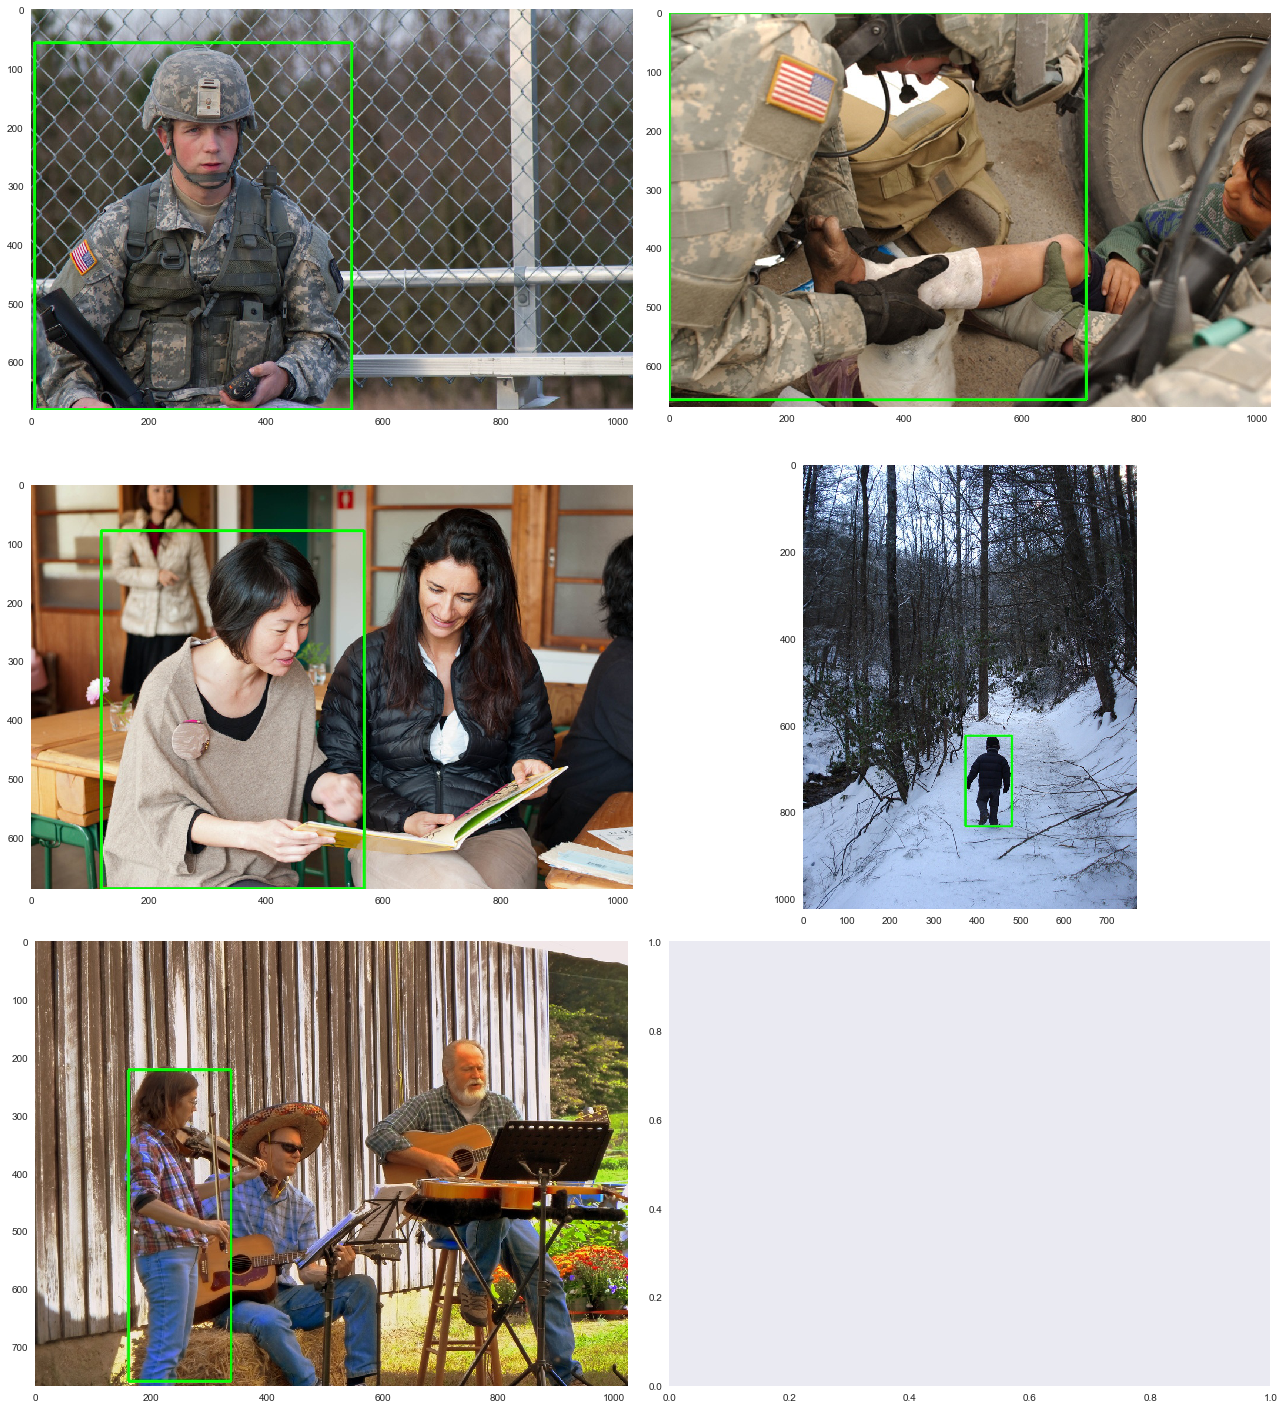

In [1237]:
files=[pilot_path+'photos/'+str(i)+'.jpg' for i in list(sub)[:5]]
photos=dict()
i=0
for f in files:
    p=list(sub)[i]
    photos[f] = [a[4:8] for a in photo_annotations[mapping[p][0]] if a[2] in human_parts]
    i+=1
draw_photos_with_rectangle(photos,col_size=2)

## Pilot2

In [12]:
pilot_path2 = '/data/rakhasan/bystander-detection/pilot-study2/'

In [1305]:
total= 176573
to_take = 5000
ratios = [int(x*to_take/total) for x in [46010, 43462, 33738, 29168, 24195]]
print('ratios:',ratios, sum(ratios))


'''For the pilot2, do not use photos that were used in pilot1'''
one_person_photos = list(final_annotations[1].keys())[100:100+ratios[0]+5]
two_person_photos = list(final_annotations[2].keys())[50:50+int((ratios[1])/2)]
three_person_photos = list(final_annotations[3].keys())[34:34+int((ratios[2])/3)]
four_person_photos = list(final_annotations[4].keys())[25:25+int((ratios[3])/4)]
five_person_photos = list(final_annotations[5].keys())[20:20+int((ratios[4])/5)]

one_person_annotations = [final_annotations[1][k][0] for k in one_person_photos]
two_person_annotations = []
for k in two_person_photos:
    for a in final_annotations[2][k]:
        two_person_annotations.append(a)
three_person_annotations = []
for k in three_person_photos:
    for a in final_annotations[3][k]:
        three_person_annotations.append(a)
four_person_annotations = []
for k in four_person_photos:
    for a in final_annotations[4][k]:
        four_person_annotations.append(a)
five_person_annotations = []
for k in five_person_photos:
    for a in final_annotations[5][k]:
        five_person_annotations.append(a)
print(len(one_person_annotations),len(two_person_annotations),len(three_person_annotations),
      len(four_person_annotations), len(five_person_annotations),
      len(one_person_annotations)+len(two_person_annotations)+len(three_person_annotations)+
      len(four_person_annotations)+len(five_person_annotations))


ratios: [1302, 1230, 955, 825, 685] 4997
1307 1230 954 824 685 5000


In [166]:
'''Number of photos containing number of people'''
stimuli=[1307, 1230, 954, 824, 685]
[stimuli[i-1]//i for i in range(1,6)]

[1307, 615, 318, 206, 137]

In [13]:
'''Concate the annotations and then randomly shuffle'''
# mappings_pilot2 = one_person_annotations + two_person_annotations + three_person_annotations+ four_person_annotations + five_person_annotations
# random.seed(1234)
# random.shuffle(mappings_pilot2)
# pickle.dump(mappings_pilot2, open(pilot_path2+'mappings_pilot2','wb'))
mappings_pilot2 = pickle.load(open(pilot_path2+'mappings_pilot2','rb'))
len(mappings_pilot2)

5000

In [14]:
mappings_pilot2[850]

['03354db5d57c47e8',
 'xclick',
 '/m/01g317',
 '1',
 '0.935625',
 '0.972500',
 '0.446529',
 '0.519700',
 '1',
 '0',
 '0',
 '0',
 '0']

In [160]:
counts =defaultdict(int)
for m in mappings_pilot2:
    counts[m[0]]+=1


In [1316]:
'''Add BB in the photos'''
#add_bb_to_photo(mapping=mappings_pilot2, output_dir=pilot_path2+'/photos/', rotation_df=rotation_df)

100%|██████████| 5000/5000 [59:24<00:00,  1.40it/s] 


4 3


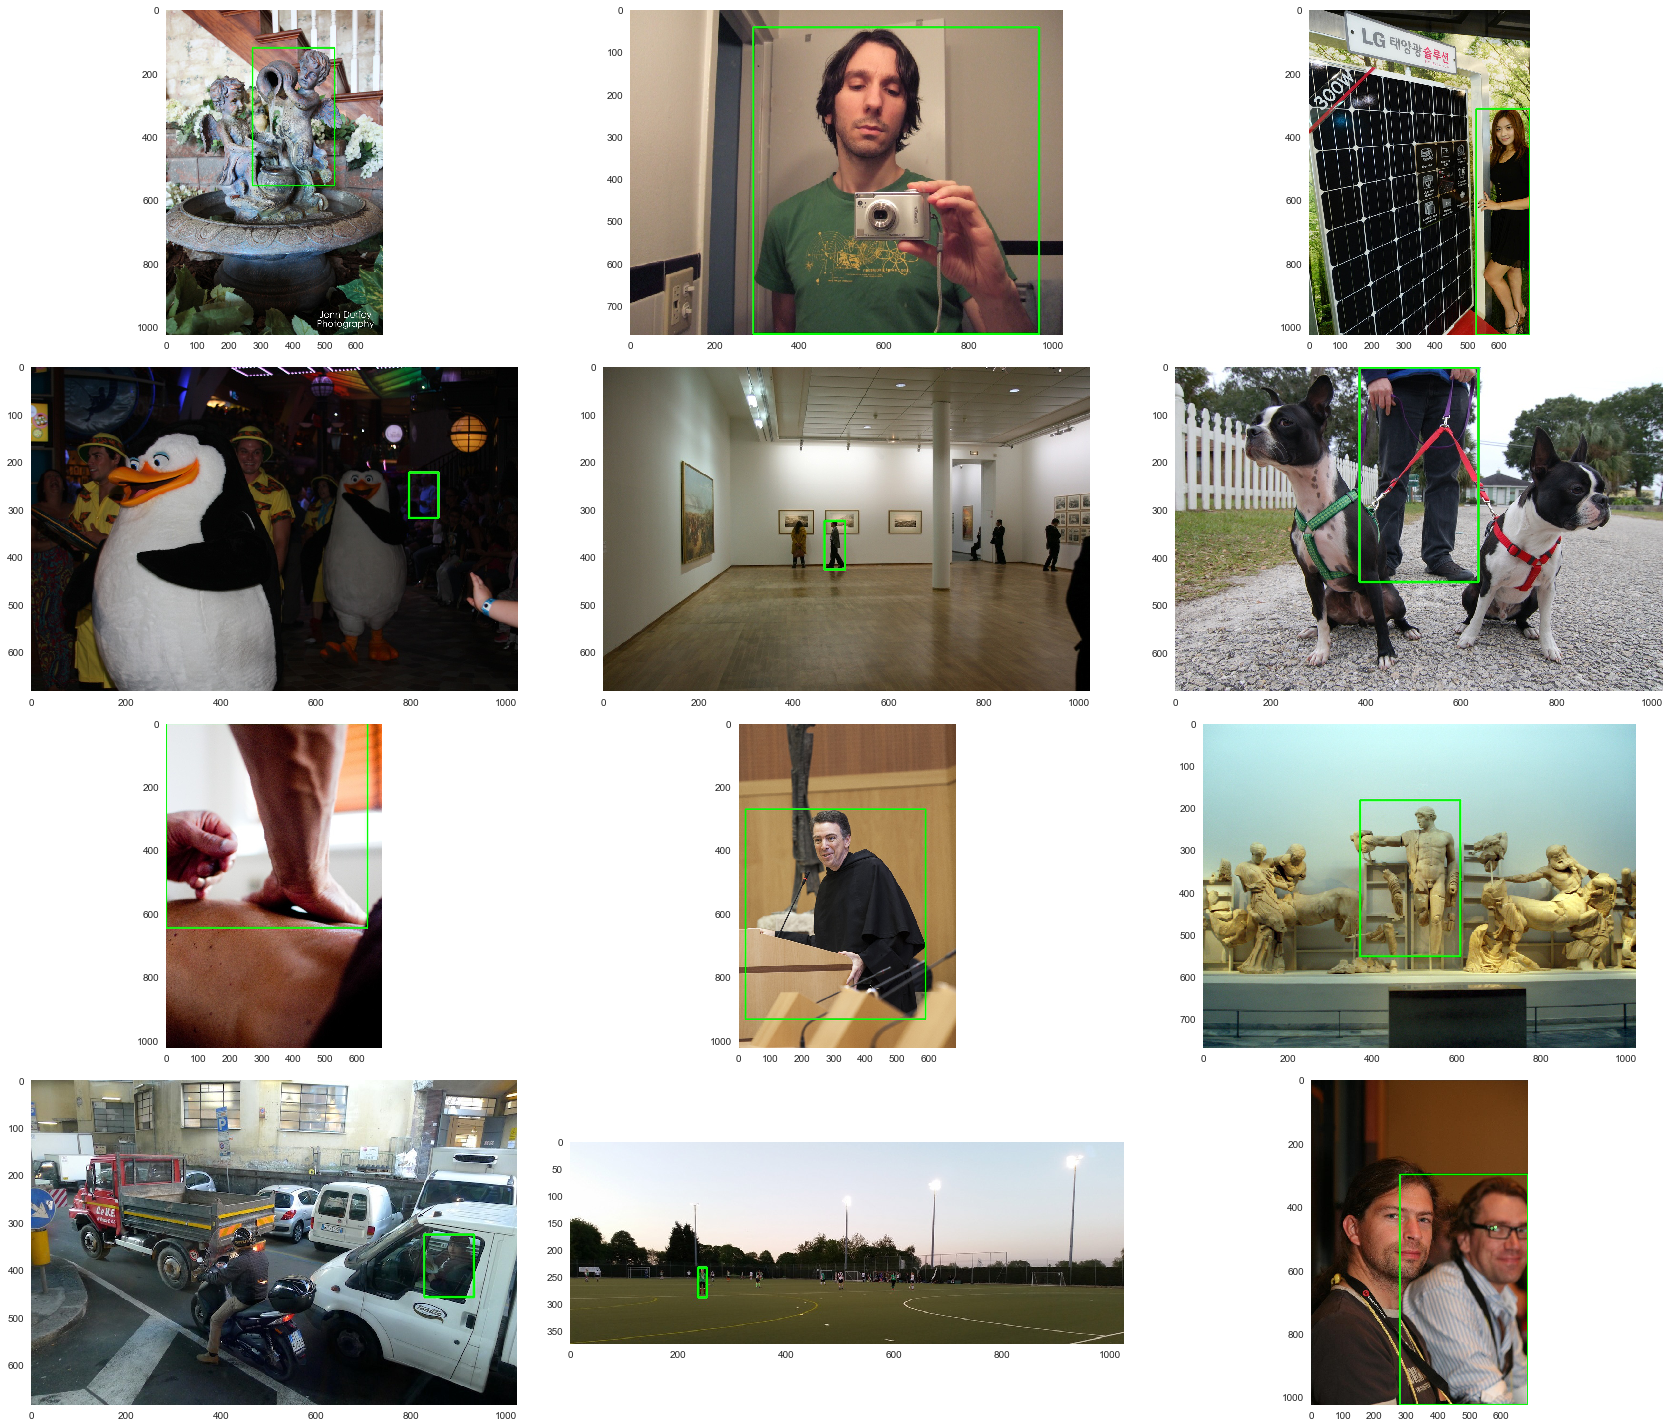

In [1318]:
files = [pilot_path2+'/photos/'+str(i)+'.jpg' for i in range(12)]
draw_photos(files,col_size=3)

In [ ]:
'''Rearrange the annotation lists so that in a list adjacent photos(persons) are different'''
#from itertools import *
import itertools

two_person_annotations_seq = list(itertools.chain.from_iterable([two_person_annotations[i::2] for i in range(2)]))
three_person_annotations_seq = list(itertools.chain.from_iterable([three_person_annotations[i::3] for i in range(3)]))
four_person_annotations_seq = list(itertools.chain.from_iterable([four_person_annotations[i::4] for i in range(4)]))
five_person_annotations_seq = list(itertools.chain.from_iterable([five_person_annotations[i::5] for i in range(5)]))

In [ ]:
'''Concate the lists of annotations. The index of the annotations will be used as mapped filename'''
mapping_p2 = []
for i in range(0, 100):
    mapping_p2.append(one_person_annotations[i])
    mapping_p2.append(two_person_annotations_seq[i])
    mapping_p2.append(three_person_annotations_seq[i])
    mapping_p2.append(four_person_annotations_seq[i])
    mapping_p2.append(five_person_annotations_seq[i])

In [1306]:
'''Generate photos with single rectangles to show study participants'''
from scipy import ndimage

def add_bb_to_photo(output_dir, mapping, rotation_df):
    #output_dir = '/data/rakhasan/bystander-detection/pilot-study/photos/'
    for i in tqdm(range(len(mapping))):
        m = mapping[i]
        photo_file = get_paths([m[0]])[0]
        img = cv2.imread(photo_file)
        outimg = draw_normed_rect(img, [m[4:8]])
        rotation = rotation_df.loc[m[0]]
        if not np.isnan(rotation)[0]:
            outimg = ndimage.rotate(outimg, rotation)
        cv2.imwrite(os.path.join(output_dir, str(i) + '.jpg'),outimg)


In [ ]:
#pickle.dump(photo_annotations, open(os.path.join(path, 'per-photo-annotations.pkl'),'wb'))

### **Approaches**
1.  A simple binary classifier with some CNN and FC layers. The input will be masked images. Use some pretrained model for object detection
2. Use SVM on top of (1)
3.  With mask-rcnn, add another task for classifying bystander/subject. 

### **Possible features**
-  What body parts are visible (such as eyes, hands)?
-  Location of body parts with respect to the main rectangle.
-  Multi-person body pose might be a proxy of capturing interaction and relation among different people.
-  May be color distribution as a proxy of looks/clothing?